## Example Analysis

In [1]:
import os
from PyFinModeler import (
    Company, AssumptionSet, ForecastRule, ForecastModel,
    DividendDiscountModel, ValuationSummaryReport, ScenarioModel,
    ChartGenerator, BorsdataCollector, BorsdataKPICollector,
    FinancialItem, FinancialItemType, create_markdown_table, create_markdown_table_from_dicts
)
from IPython.display import Markdown, display

### Step 1 Load API Key

In [2]:
api_key = os.environ.get("BORSDATA_API_KEY")
if not api_key:
    raise ValueError("API Key not found. Please set BORSDATA_API_KEY.")

### Step 2: Initialize collectors

In [3]:
collector = BorsdataCollector(api_key=api_key)
kpi_collector = BorsdataKPICollector(api_key=api_key)

### Step 3: Set global Params 

In [4]:
company_name = "Atlas Copco B"
report_type = "year"

### Step 4: Fetch Company (Atlas Copco B)

In [5]:
company, company_id, company_info = collector.fetch_company_by_name(company_name, report_type=report_type)

if company is None:
    print("Company not found.")
    exit()
else:
    display(Markdown(create_markdown_table(company_info)))

AttributeError: 'Company' object has no attribute 'other_financial_items'

### Step 4: Fetch real KPIs from Nordic endpoint

In [ ]:
# Step 4: Fetch real KPIs from Nordic endpoint

# Fetch Net Income Margin (Net Margin %)
try:
    net_income_margin_values = kpi_collector.fetch_kpis(company_id, kpi_id=30, report_type="year", price_type="mean")
    net_income_margin = list(net_income_margin_values.values())[0] / 100  
except Exception as e:
    print(f"Warning: Could not fetch Net Income Margin. Error: {str(e)}")
    net_income_margin = 0.20  # fallback

# Fetch Payout Ratio %
try:
    payout_ratio_values = kpi_collector.fetch_kpis(company_id, kpi_id=20, report_type="year", price_type="mean")
    payout_ratio = list(payout_ratio_values.values())[0] / 100
except Exception as e:
    print(f"Warning: Could not fetch Payout Ratio. Error: {str(e)}")
    payout_ratio = 1.0

# Fetch Number of Shares
try:
    shares_values = kpi_collector.fetch_kpis(company_id, kpi_id=61, report_type="year", price_type="mean")
    shares_outstanding = list(shares_values.values())[0]
except Exception as e:
    print(f"Warning: Could not fetch Number of Shares. Error: {str(e)}")
    shares_outstanding = 100_000_000

In [ ]:
display(Markdown(create_markdown_table_from_dicts([payout_ratio_values, shares_values], ["Payout ratio", "nr shares"])))
display(Markdown(create_markdown_table_from_dicts([net_income_margin_values], ["net income margin"])))


| Year | Payout ratio | nr shares |
|:----| :----: | :----: |
| 2025 | 50.00 | 4868.80 |
| 2024 | 49.18 | 4874.20 |
| 2023 | 48.61 | 4873.00 |
| 2022 | 47.71 | 4870.00 |
| 2021 | 51.04 | 4870.80 |
| 2020 | 60.03 | 4861.60 |
| 2019 | 51.47 | 4858.80 |
| 2018 | 46.80 | 4854.00 |
| 2017 | 50.97 | 4856.00 |
| 2016 | 69.31 | 4864.00 |
| 2015 | 65.46 | 4869.60 |
| 2014 | 119.87 | 4862.40 |
| 2013 | 55.28 | 4853.20 |
| 2012 | 48.03 | 4860.00 |
| 2011 | 47.08 | 4869.20 |
| 2010 | 49.08 | 4868.00 |
| 2009 | 58.48 | 4864.00 |
| 2008 | 36.01 | 4876.00 |
| 2007 | 49.26 | 4888.00 |
| 2006 | 19.48 | 5024.00 |


| Year | net income margin |
|:----| :----: |
| 2025 | 16.54 |
| 2024 | 16.85 |
| 2023 | 16.24 |
| 2022 | 16.61 |
| 2021 | 16.35 |
| 2020 | 14.81 |
| 2019 | 15.92 |
| 2018 | 17.13 |
| 2017 | 14.32 |
| 2016 | 11.77 |
| 2015 | 11.47 |
| 2014 | 12.98 |
| 2013 | 14.39 |
| 2012 | 15.35 |
| 2011 | 15.96 |
| 2010 | 14.20 |
| 2009 | 9.79 |
| 2008 | 13.69 |
| 2007 | 11.74 |
| 2006 | 30.39 |


### Setup assumptions

In [ ]:
# Step 5: Setup Assumptions (Base Case)
base_assumptions = AssumptionSet()
base_assumptions.set_assumption("revenue_growth", 0.06)
base_assumptions.set_assumption("tax_rate", 0.25)


# Step 6: Setup Forecast Model

In [ ]:
forecast_model = ForecastModel(company=company, assumptions=base_assumptions, periods=5)

### Step 7: Setup KPIs using financials

In [ ]:
company.kpi_manager.add_kpi("Gross_Margin_Percent", "(gross_Income) / revenues")
company.kpi_manager.add_kpi("Net_Income_Margin", "profit_To_Equity_Holders / revenues")
company.kpi_manager.calculate_kpi("Gross_Margin_Percent")
company.kpi_manager.calculate_kpi("Net_Income_Margin")

{'2020': 0.14810546463968252,
 '2021': 0.1634629255626082,
 '2022': 0.16612064390589068,
 '2023': 0.16239633044525784,
 '2024': 0.16847786118763824,
 '2025': 0.16535999298095702,
 '2026': 0.16535999298095705,
 '2027': 0.16535999298095705,
 '2028': 0.16535999298095702,
 '2029': 0.16535999298095702}

### Step 8: Add Dividend FinancialItem


In [ ]:
dividends = FinancialItem(name="Dividends", item_type=FinancialItemType.DIVIDEND)
company.cash_flow_statement.add_item(dividends)

### Step 9: Define Forecast Rules


In [ ]:
forecast_model.add_forecast_rule(ForecastRule(
    item_name="revenues",
    method="growth_rate",
    params={"rate": base_assumptions.get_assumption("revenue_growth")}
))

forecast_model.add_forecast_rule(ForecastRule(
    item_name="profit_To_Equity_Holders",
    method="margin_of",
    params={"base_item": "revenues", "margin": net_income_margin}
))

def forecast_dividends(item, model):
    profit_item = model._find_item("profit_To_Equity_Holders")
    for period, profit in profit_item.forecasted.items():
        # Calculate the dividend based on the profit and payout ratio
        dividend = profit * payout_ratio
        item.add_forecasted(period, dividend)

forecast_model.add_forecast_rule(ForecastRule(
    item_name="Dividends",
    method="custom_function",
    custom_function=forecast_dividends
))

### Step 10: Run Forecast

In [ ]:
forecast_model.run_forecast()

# Step 11: Valuation using DDM

In [ ]:
ddm_model = DividendDiscountModel(
    company=company,
    base_item_for_dividends="profit_To_Equity_Holders",
    discount_rate=0.08,
    payout_ratio=payout_ratio,
    terminal_growth_rate=0.06,
    periods=5
)

market_price = 131.55

report = ValuationSummaryReport(
    company=company,
    valuation_model=ddm_model,
    shares_outstanding=shares_outstanding,
    market_price=market_price
)

report.generate()


Valuation Summary for Atlas Copco B (ATCO B)
Currency: SEK
Forecast Periods: 5 (Annual)
Payout Ratio: 50.0%
Discount Rate: 8.0%
Terminal Growth Rate: 6.0%
--------------------------------------------------
Intrinsic Value (Total Equity): 774,617.56 SEK
Intrinsic Value Per Share: 159.10 SEK
Current Market Price: 131.55 SEK
Margin of Safety: 20.9%


### Step 12: Scenario Modeling


In [ ]:
print("\nRunning Scenario Analysis...\n")

scenario_model_base = ScenarioModel(
    company=company,
    shares_outstanding=shares_outstanding,
    market_price=market_price,
    periods=5,
    payout_ratio=payout_ratio,
    base_item_for_dividends="profit_To_Equity_Holders",
    terminal_growth_rate=0.06,
    discount_rate=0.08
)
# Bull Scenario
bull_assumptions = AssumptionSet()
bull_assumptions.set_assumption("revenue_growth", 0.08)
bull_result = scenario_model_base.run_scenario(bull_assumptions, label="Bull Case")
print(bull_result)

# Bear Scenario
bear_assumptions = AssumptionSet()
bear_assumptions.set_assumption("revenue_growth", 0.03)
bear_result = scenario_model_base.run_scenario(bear_assumptions, label="Bear Case")
print(bear_result)


Running Scenario Analysis...

{'Scenario': 'Bull Case', 'Intrinsic Value Total': 774617.5599597738, 'Intrinsic Value Per Share': 159.0982564561395, 'Margin of Safety': 0.2094128198870352}
{'Scenario': 'Bear Case', 'Intrinsic Value Total': 774617.5599597738, 'Intrinsic Value Per Share': 159.0982564561395, 'Margin of Safety': 0.2094128198870352}


In [ ]:
forecast_model.periods

5

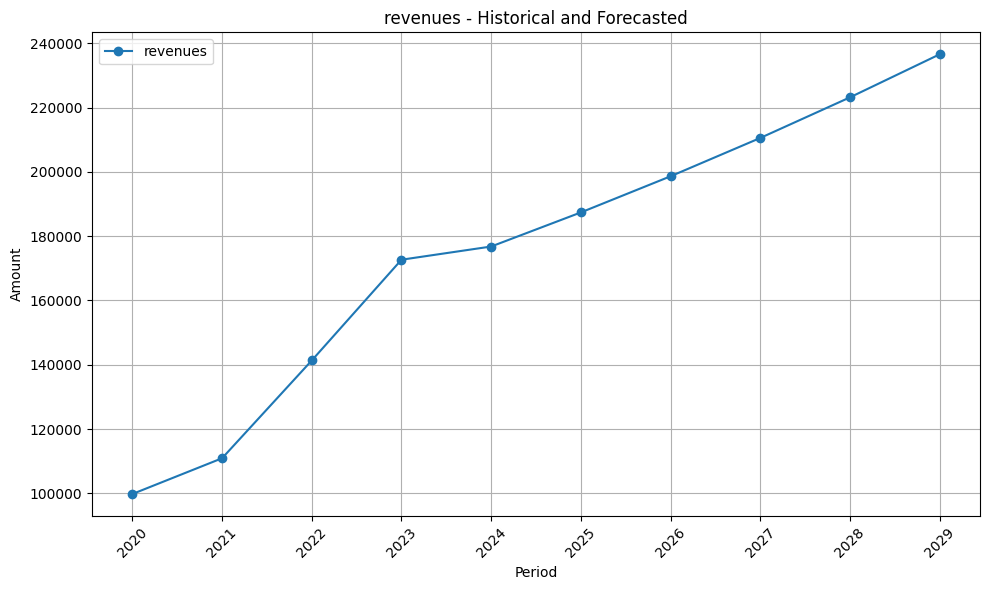

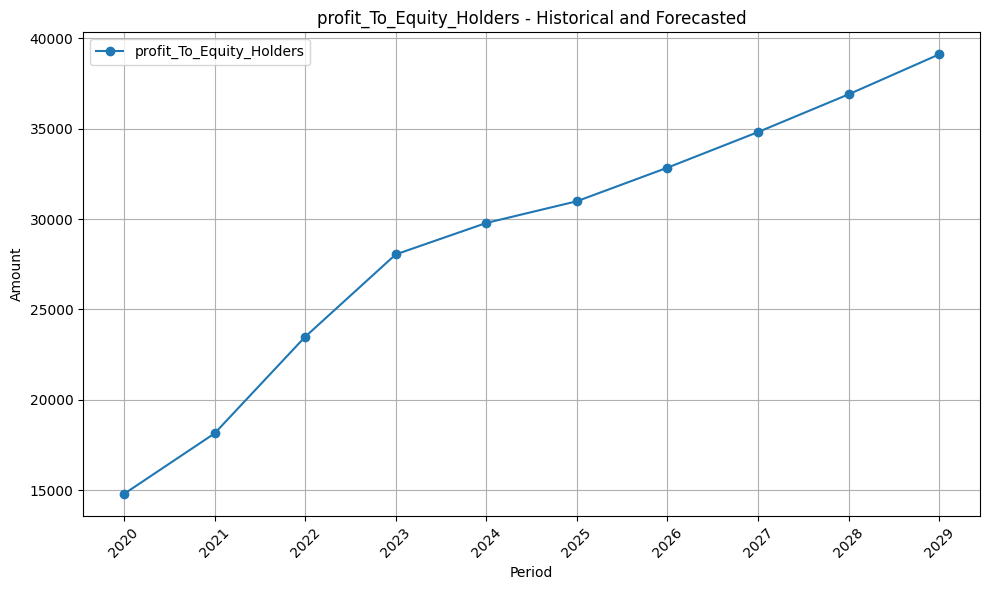

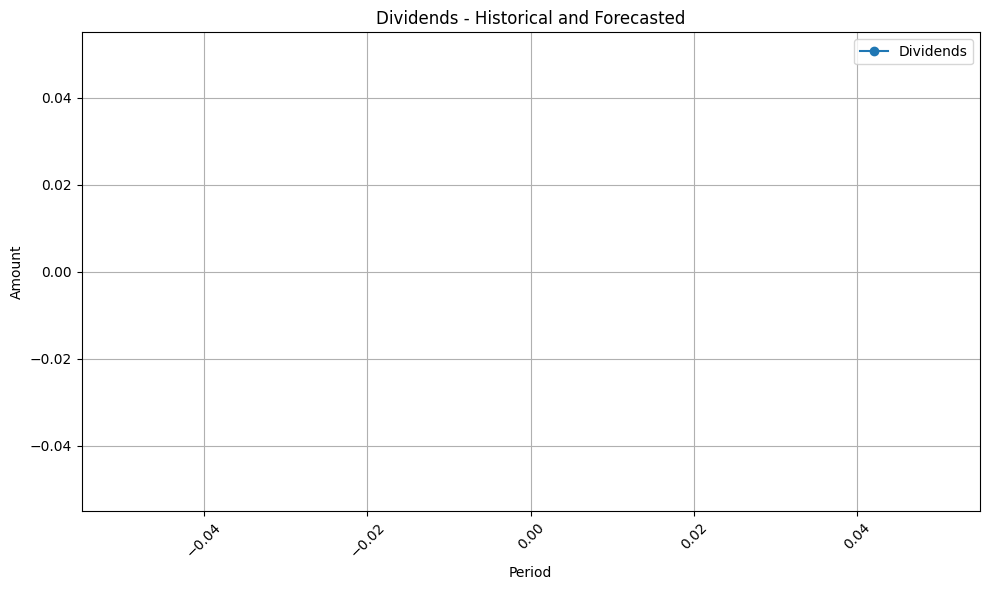

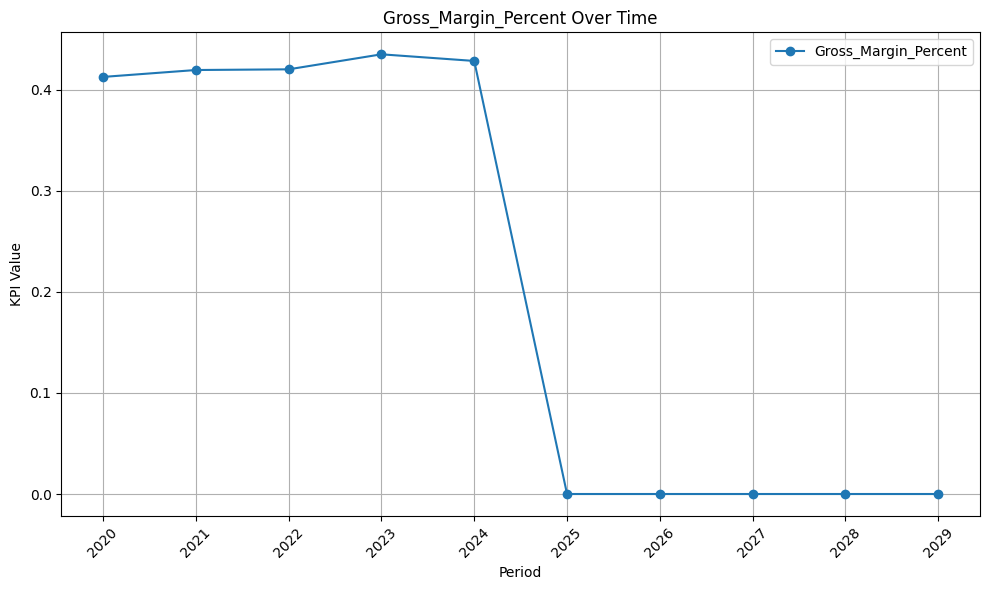

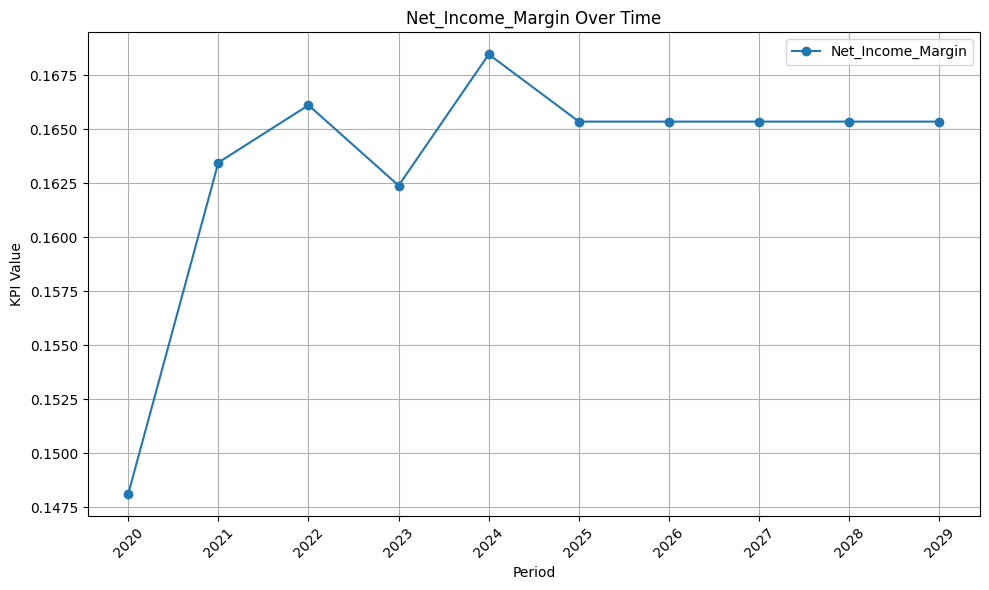

In [ ]:
# Step 12: Charting
chart = ChartGenerator(company)

# Plot Revenues
try:
    chart.plot_financial_item("revenues")
except Exception as e:
    print(f"Warning: Cannot plot revenues: {str(e)}")

# Plot Profit to Equity Holders
try:
    chart.plot_financial_item("profit_To_Equity_Holders")
except Exception as e:
    print(f"Warning: Cannot plot Profit to Equity Holders: {str(e)}")

# Plot Dividends
try:
    chart.plot_financial_item("Dividends")
except Exception as e:
    print(f"Warning: Cannot plot Dividends: {str(e)}")

# Plot KPIs
try:
    chart.plot_kpi(company.kpi_manager, "Gross_Margin_Percent")
    chart.plot_kpi(company.kpi_manager, "Net_Income_Margin")
except Exception as e:
    print(f"Warning: Cannot plot KPI: {str(e)}")